In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from biaxread import *
from scipy.signal import medfilt

%matplotlib inline

In [2]:
def rslope(x,y,window):
    """
    Takes a data vector and a window to produce a vector of the running average slope.
    The window specifies the number of points on either side of the central point, so
    the total number of points in the slope fitting is 2*window+1.  Fitting is
    done by the least squares method where the slope is defined by the equation below.
    the beginning and ends are padded with NaN, so fewer points are in those slope
    estimates.  Addition and subtraction to the totals is used so that the sum is not
    recomputed each time, speeding the process.

                    sum(x)*sum(y)
        Sum(x*y) -  -------------
                          n
    m = -------------------------
                     (sum(x))^2
        sum(x^2) - --------------
                          n
    """

    import numpy as np

    # Check that x and y are the same length
    if len(x) != len(y):
        print "Error: x and y must be the same length"
        return 0

    N = len(x) # Number of points in the dataset
    slopes = np.ones(N) # Make array for slopes

    # Pad data with window number of points NaN on either side
    x_padded = np.empty(2*window+N)
    x_padded[0:window] = 0
    x_padded[window:N+window] = x
    x_padded[N+window:2*window+N] = 0

    y_padded = np.empty(2*window+N)
    y_padded[0:window] = 0
    y_padded[window:N+window] = y
    y_padded[N+window:2*window+N] = 0

    sum_x    = np.sum(x_padded[0:2*window+1])
    sum_y    = np.sum(y_padded[0:2*window+1])
    sum_x_sq = np.sum(x_padded[0:2*window+1]*x_padded[0:2*window+1])
    sum_xy   = np.sum(x_padded[0:2*window+1]*y_padded[0:2*window+1])

    n = np.empty(N)
    n[0:window] = np.arange(window+1,2*window+1)
    n[window:N-window] = window*2+1
    n[N-window:N] = np.arange(2*window,window,-1)

    slopes[0] = (sum_xy - (sum_x*sum_y/n[0]))/(sum_x_sq - (sum_x*sum_x/n[0]))

    for i in range(1,N):
        sum_x    = sum_x - x_padded[i-1] + x_padded[2*window+i]
        sum_y    = sum_y - y_padded[i-1] + y_padded[2*window+i]
        sum_x_sq = sum_x_sq - x_padded[i-1]*x_padded[i-1] + \
            x_padded[2*window+i]*x_padded[2*window+i]
        sum_xy   = sum_xy - x_padded[i-1]*y_padded[i-1] +\
            x_padded[2*window+i]*y_padded[2*window+i]
        slopes[i] = (sum_xy - (sum_x*sum_y/n[i]))/(sum_x_sq - (sum_x*sum_x/n[i]))
    return slopes

In [3]:
def ReadExp(exp,path,disp_low,disp_high):
    data = ReadAscii('%s/%s/%s_data.txt'%(path,exp,exp))
    lower_row = find_nearest(np.ravel(data['LP_Disp']),disp_low)
    upper_row = find_nearest(np.ravel(data['LP_Disp']),disp_high)
    print lower_row,upper_row
    data = data[lower_row:upper_row]
    data['mu'] = data['mu'] - data['mu'][0]
    return data

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')



def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

path = '/Users/jleeman/Dropbox/PennState/BiaxExperiments'
dis_low = 9*1000
dis_high = 17*1000
dis_high = 15.1*1000
p4343 = ReadExp('p4343',path,dis_low,dis_high)
p4344 = ReadExp('p4344',path,dis_low,dis_high)
p4345 = ReadExp('p4345',path,dis_low,dis_high)
p4346 = ReadExp('p4346',path,dis_low,dis_high)
p4347 = ReadExp('p4347',path,dis_low,dis_high)
p4348 = ReadExp('p4348',path,dis_low,dis_high)
p4342 = ReadExp('p4342',path,dis_low,dis_high)
p4350 = ReadExp('p4350',path,dis_low,dis_high)
p4351 = ReadExp('p4351',path,dis_low,dis_high)



Number of records: 5887623
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
-------------------------------------------------
|        row_num|            mic|        5887623|
|        LP_Disp|            MPa|        5887623|
|     Shr_stress|         micron|        5887623|
|       nor_disp|            MPa|        5887623|
|     Nor_stress|            sec|        5887623|
|           Time|         micron|        5887623|
|         OB_Top|         micron|        5887623|
|      OB_Bottom|         micron|        5887623|
|        OB_Diff|             Hz|        5887623|
|      Samp_Freq|              .|        5887623|
|             mu|         micron|        5887623|
-------------------------------------------------
998330 1681328

Number of records: 5800626
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
-------------------------------

In [4]:
### Read subset
path = '/Users/jleeman/Dropbox/PennState/BiaxExperiments'
dis_low = 30*1000
dis_high = 30.55*1000
p4343_subset = ReadExp('p4343',path,30041,dis_high)
p4345_subset = ReadExp('p4345',path,30034,dis_high)
p4347_subset = ReadExp('p4347',path,30016,dis_high)
p4342_subset = ReadExp('p4342',path,30031,dis_high)
p4351_subset = ReadExp('p4351',path,30049,dis_high)


Number of records: 5887623
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
-------------------------------------------------
|        row_num|            mic|        5887623|
|        LP_Disp|            MPa|        5887623|
|     Shr_stress|         micron|        5887623|
|       nor_disp|            MPa|        5887623|
|     Nor_stress|            sec|        5887623|
|           Time|         micron|        5887623|
|         OB_Top|         micron|        5887623|
|      OB_Bottom|         micron|        5887623|
|        OB_Diff|             Hz|        5887623|
|      Samp_Freq|              .|        5887623|
|             mu|         micron|        5887623|
-------------------------------------------------
3438660 3489576

Number of records: 6028557
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
------------------------------

In [5]:
data_path = '/Users/jleeman/Dropbox/PennState/BiaxExperiments'
#dis_low = 30*1000
#dis_high = 30.55*1000
#p4343 = ReadExp('p4343',path,30041,dis_high)
#p4345 = ReadExp('p4345',path,30034,dis_high)
#p4347 = ReadExp('p4347',path,30016,dis_high)
#p4342 = ReadExp('p4342',path,30031,dis_high)
#p4351 = ReadExp('p4351',path,30049,dis_high)

p4343_raw = ReadAscii(data_path+'/p4343/p4343_data.txt')


Number of records: 5887623
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
-------------------------------------------------
|        row_num|            mic|        5887623|
|        LP_Disp|            MPa|        5887623|
|     Shr_stress|         micron|        5887623|
|       nor_disp|            MPa|        5887623|
|     Nor_stress|            sec|        5887623|
|           Time|         micron|        5887623|
|         OB_Top|         micron|        5887623|
|      OB_Bottom|         micron|        5887623|
|        OB_Diff|             Hz|        5887623|
|      Samp_Freq|              .|        5887623|
|             mu|         micron|        5887623|
-------------------------------------------------


In [6]:
# Following colorbar in other figure
colors = [(244,120,72),(221,212,127),(133,205,183),(38,180,231), (106,87,164)] 

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(colors)):
    r, g, b = colors[i]
    colors[i] = (r / 255., g / 255., b / 255.)

/Users/jleeman/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


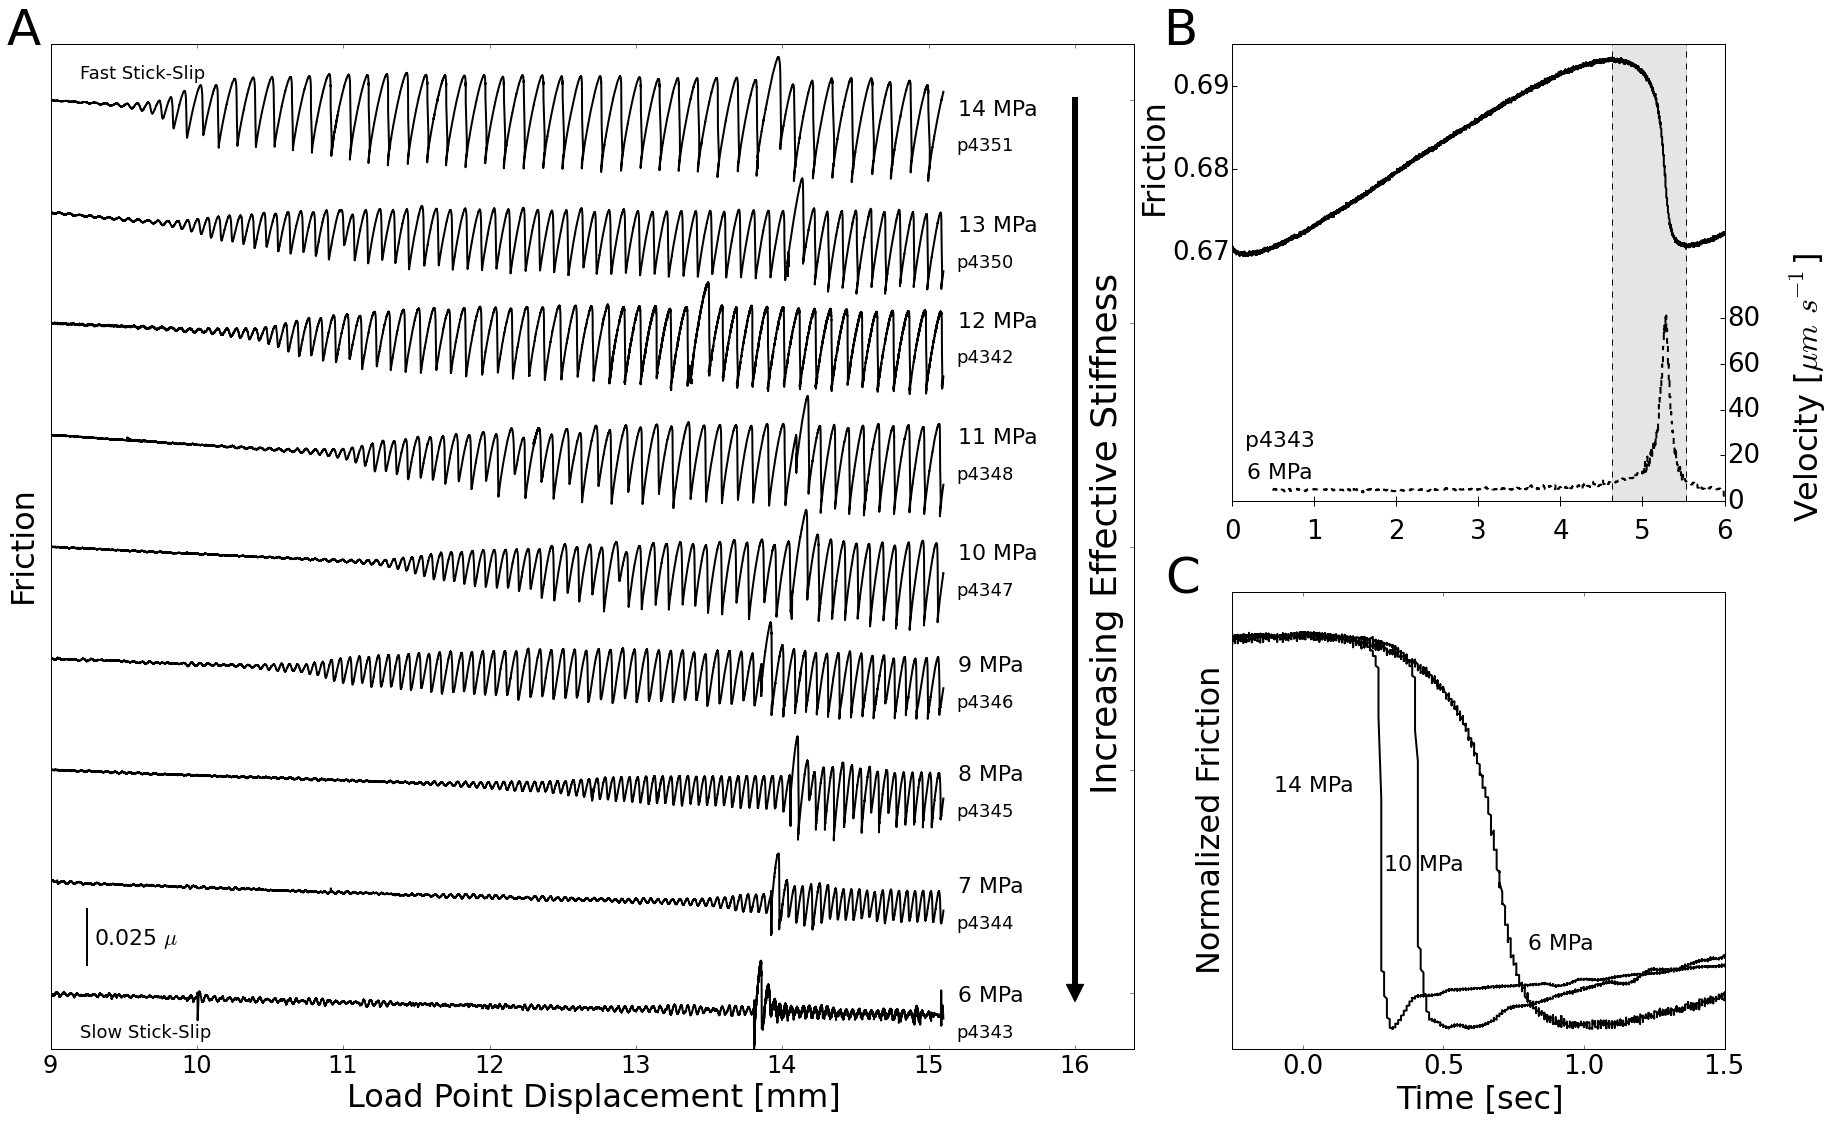

In [7]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# Setup figure and axes
# Generally plots is ~1.33x width to height (10,7.5 or 12,9)
fig = plt.figure(figsize=(30,18))
ax1 = plt.subplot2grid((2,3), (0, 0), colspan=2, rowspan=2)
# l,b,w,h
axB = plt.subplot2grid((2,3), (0, 2))
axBv = axB.twinx()
axC = plt.subplot2grid((2,3), (1, 2))
# Set labels and tick sizes
ax1.set_xlabel(r'Load Point Displacement [mm]',fontsize=32)
ax1.set_ylabel(r'Friction',fontsize=32)
ax1.tick_params(axis='both', which='major', labelsize=24)

# Turns off chart clutter

# Turn off top and right tick marks
# ax1.get_xaxis().tick_bottom()
# ax1.get_yaxis().tick_left()
#ax1.get_yaxis().set_ticks([])

# Turn off top and right splines
# ax1.spines["top"].set_visible(False)
# ax1.spines["right"].set_visible(False)

# Plotting
window_size = 51
order = 5
decimate = 10
ax1.plot(p4343['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4343['mu']), window_size, order)[::decimate],label='6 MPa',color='k',linewidth=2)
ax1.plot(p4344['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4344['mu']), window_size, order)[::decimate]+0.05,label='7 MPa',color='k',linewidth=2)
ax1.plot(p4345['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4345['mu']), window_size, order)[::decimate]+0.05*2,label='8 MPa',color='k',linewidth=2)
ax1.plot(p4346['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4346['mu']), window_size, order)[::decimate]+0.05*3,label='9 MPa',color='k',linewidth=2)
ax1.plot(p4347['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4347['mu']), window_size, order)[::decimate]+0.05*4,label='10 MPa',color='k',linewidth=2)
ax1.plot(p4348['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4348['mu']), window_size, order)[::decimate]+0.05*5,label='11 MPa',color='k',linewidth=2)
ax1.plot(p4342['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4342['mu']), window_size, order)[::decimate]+0.05*6,label='12 MPa',color='k',linewidth=2)
ax1.plot(p4350['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4350['mu']), window_size, order)[::decimate]+0.05*7,label='13 MPa',color='k',linewidth=2)
ax1.plot(p4351['LP_Disp'][::decimate]/1000.,savitzky_golay(np.ravel(p4351['mu']), window_size, order)[::decimate]+0.05*8,label='14 MPa',color='k',linewidth=2)

#ax1.text(9.1,np.mean(p4343['mu'])+0.05*0.25,r'$\mu = $%0.2f' %np.mean(p4343['mu']),fontsize=16,color=tableau20[0])
#ax1.text(9.1,np.mean(p4344['mu'])+0.05*1.25,r'$\mu = $%0.2f' %np.mean(p4344['mu']),fontsize=16,color=tableau20[2])
#ax1.text(9.1,np.mean(p4345['mu'])+0.05*2.25,r'$\mu = $%0.2f' %np.mean(p4345['mu']),fontsize=16,color=tableau20[4])
#ax1.text(9.1,np.mean(p4346['mu'])+0.05*3.25,r'$\mu = $%0.2f' %np.mean(p4346['mu']),fontsize=16,color=tableau20[6])
#ax1.text(9.1,np.mean(p4347['mu'])+0.05*4.25,r'$\mu = $%0.2f' %np.mean(p4347['mu']),fontsize=16,color=tableau20[8])
#ax1.text(9.1,np.mean(p4348['mu'])+0.05*5.25,r'$\mu = $%0.2f' %np.mean(p4348['mu']),fontsize=16,color=tableau20[10])
#ax1.text(9.1,np.mean(p4342['mu'])+0.05*6.25,r'$\mu = $%0.2f' %np.mean(p4342['mu']),fontsize=16,color=tableau20[12])
#ax1.text(9.1,np.mean(p4350['mu'])+0.05*7.25,r'$\mu = $%0.2f' %np.mean(p4350['mu']),fontsize=16,color=tableau20[14])
#ax1.text(9.1,np.mean(p4351['mu'])+0.05*8.25,r'$\mu = $%0.2f' %np.mean(p4351['mu']),fontsize=16,color=tableau20[18])

x_label_pos = 17.2-2 # was 9.1
n_avg_y_pos = -10000
ax1.text(x_label_pos,np.mean(p4343['mu'][n_avg_y_pos:])+0.05*0+0.006,r'6 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4344['mu'][n_avg_y_pos:])+0.05*1+0.006,r'7 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4345['mu'][n_avg_y_pos:])+0.05*2+0.006,r'8 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4346['mu'][n_avg_y_pos:])+0.05*3+0.006,r'9 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4347['mu'][n_avg_y_pos:])+0.05*4+0.006,r'10 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4348['mu'][n_avg_y_pos:])+0.05*5+0.006,r'11 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4342['mu'][n_avg_y_pos:])+0.05*6+0.006,r'12 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4350['mu'][n_avg_y_pos:])+0.05*7+0.006,r'13 MPa',fontsize=22,color='k')
ax1.text(x_label_pos,np.mean(p4351['mu'][n_avg_y_pos:])+0.05*8+0.006,r'14 MPa',fontsize=22,color='k')

ax1.text(x_label_pos,np.mean(p4343['mu'][n_avg_y_pos:])+0.05*0-0.01,r'p4343',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4344['mu'][n_avg_y_pos:])+0.05*1-0.01,r'p4344',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4345['mu'][n_avg_y_pos:])+0.05*2-0.01,r'p4345',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4346['mu'][n_avg_y_pos:])+0.05*3-0.01,r'p4346',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4347['mu'][n_avg_y_pos:])+0.05*4-0.01,r'p4347',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4348['mu'][n_avg_y_pos:])+0.05*5-0.01,r'p4348',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4342['mu'][n_avg_y_pos:])+0.05*6-0.01,r'p4342',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4350['mu'][n_avg_y_pos:])+0.05*7-0.01,r'p4350',fontsize=18,color='k')
ax1.text(x_label_pos,np.mean(p4351['mu'][n_avg_y_pos:])+0.05*8-0.01,r'p4351',fontsize=18,color='k')

# Make Arrow
arrow_x_pos = 18-2.
ax1.plot([arrow_x_pos,arrow_x_pos],[0,0.4],linewidth=6,color='k')
ax1.scatter([arrow_x_pos],[0],marker='v',s=300,color='k')

ax1.yaxis.set_ticklabels([])

# Scale Bar
ax1.plot([9.25,9.25],[0.0125,0.0375],color='k',linewidth=2)
ax1.text(9.3,0.022,r'0.025 $\mu$',fontsize=22)

#ax1.text(17.07,-0.013,'0.99',fontsize=24)
#ax1.text(17.07,0.38,'0.70',fontsize=24)
ax1.text(arrow_x_pos+0.1,0.31,r'Increasing Effective Stiffness',fontsize=36,rotation=90)
ax1.text(9.2, -0.02, r'Slow Stick-Slip', fontsize=18)
ax1.text(9.2, 0.41, r'Fast Stick-Slip', fontsize=18)

# Set limits
ax1.set_xlim(9,16.4)
ax1.set_ylim(-0.025,0.425)
ax1.text(-0.04,1.0,'A',transform = ax1.transAxes,fontsize=50)

#################################################################################
# Plotting
start_row = 5096
end_row = 7096+500
friction = p4343_subset['mu'][start_row:end_row]
friction = friction - np.min(friction)
friction = friction/np.max(friction)
max_friction_idx = np.argmax(friction)
time = p4343_subset['Time'][start_row:end_row]
time = time - time[max_friction_idx]
axC.plot(time,friction,label='6 MPa',color='k',linewidth=2)
axC.text(-0.1,0.6,'14 MPa', fontsize=22)

start_row = 7929
end_row = 9929+500
friction = p4347_subset['mu'][start_row:end_row]
friction = friction - np.min(friction)
friction = friction/np.max(friction)
max_friction_idx = np.argmax(friction)
time = p4347_subset['Time'][start_row:end_row]
time = time - time[max_friction_idx]
axC.plot(time,friction,label='10 MPa',color='k',linewidth=2)
axC.text(0.29,0.4,'10 MPa', fontsize=22)

start_row = 11398
end_row = 13398+500
friction = p4351_subset['mu'][start_row:end_row]
friction = friction - np.min(friction)
friction = friction/np.max(friction)
max_friction_idx = np.argmax(friction)
time = p4351_subset['Time'][start_row:end_row]
time = time - time[max_friction_idx]
axC.plot(time,friction,label='14 MPa',color='k',linewidth=2)
axC.text(0.8,0.2,'6 MPa', fontsize=22)

# Set limits
axC.set_xlim(-0.25,1.5)
axC.set_ylim(-0.05,1.1)

# Set labels and tick sizes
axC.set_xlabel(r'Time [sec]',fontsize=32)
axC.set_ylabel(r'Normalized Friction',fontsize=32)
axC.tick_params(axis='both', which='major', labelsize=26)
axC.get_yaxis().tick_left()
axC.get_yaxis().set_ticks([])
# Set limits
axC.set_xlim(-0.25,1.5)
axC.set_ylim(-0.05,1.1)

axC.text(-0.13,1.0,'C',transform = axC.transAxes,fontsize=50)

#################################################################################
## B Axis
#
# Plot 1
#

# Event,StartRow,FailRow,EndRow,SlipDuration,Stiffness,NptsStiffness,StiffnessIntercept,FailTime,FailDisplacement,50_Mean_Velocity,Peak_Velocity
# 413,3800095,3804529,3805433,0.900000,0.000652,3770,-21.272030,7036.910000,33692.700000,4.640566,81.252189

# Set labels and tick sizes
#axB.set_xlabel(r'Time [sec]',fontsize=18)
axB.set_ylabel(r'Friction',fontsize=32,color='k')
axBv.set_ylabel(r'Velocity [$\mu m$ $s^{-1}$]',fontsize=32)
#axBv.set_ylabel(r'Velocity [$\mu m/s$]',fontsize=18)
axB.tick_params(axis='both', which='major', labelsize=26)
axBv.tick_params(axis='both', which='major', labelsize=26)

# Change colors of plot axes
#axB.spines['left'].set_color(colors[0])
#axB.yaxis.label.set_color(colors[0])
#axB.tick_params(axis='y', colors=colors[0])

# Label Plot
axB.text(-0.13,1.0,'B',transform = axB.transAxes,fontsize=50)
axB.text(0.03,0.12,'p4343',transform = axB.transAxes,fontsize=22)
axB.text(0.03,0.05,'6 MPa',transform = axB.transAxes,fontsize=22)

# Turns off chart clutter

# Turn off top and right tick marks
axB.get_xaxis().tick_bottom()
axB.get_yaxis().tick_left()
axB.get_yaxis().set_ticks([0.67,0.68,0.69])
axBv.get_xaxis().tick_bottom()
axBv.get_yaxis().tick_right()
axBv.get_yaxis().set_ticks([0,20,40,60,80])
axBv.get_xaxis().set_ticks([0,1,2,3,4,5,6])
#axB.get_xaxis().set_ticklabels([])

axB.get_xaxis().set_tick_params(which='both', direction='inout',length=10,width=1)
axB.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)
axBv.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)

y1 = 500
y2 = 5000
y3 = 5500
y4 = 5999
velocity = rslope(np.ravel(p4343_raw['Time'][3799900:3805900]),np.ravel(p4343_raw['OB_Top'][3799900:3805900]),11)
time = np.ravel(p4343_raw['Time'][3799900:3805900]-p4343_raw['Time'][3799900])

axBv.plot(time[y1:y2],medfilt(velocity[y1:y2],35),color='k',zorder=0,linewidth=2,linestyle='--')
axBv.plot(time[y2:y3],velocity[y2:y3],color='k',zorder=0,linewidth=2,linestyle='--')
axBv.plot(time[y3:y4],medfilt(velocity[y3:y4],35),color='k',zorder=0,linewidth=2,linestyle='--')

# Plotting
axB.plot(p4343_raw['Time'][3799900:3805900]-p4343_raw['Time'][3799900],p4343_raw['mu'][3799900:3805900],label='6 MPa',color='k',zorder=1,linewidth=2)

# Mark the slip duration window
axB.axvspan(p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900], p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900], alpha=0.1, color='k')
axB.axvline(x=p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900],linestyle='--',color='k')
axB.axvline(x=p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900],linestyle='--',color='k')

# Add double headed arrow
#arrow_x = [p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900], p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900]]
#arrow_y = [0.6945,0.6945]
#arrow_y = [0.696,0.696]
#axB.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'}, annotation_clip=False)
#axB.text(arrow_x[0]-0.3,0.698,'Slip Duration',fontsize=12)

# Set limits
axB.set_xlim(0,6)
axBv.set_xlim(0,6)
axB.set_ylim(0.64,0.695)
axBv.set_ylim(0,200)

axB.yaxis.set_label_coords(-0.12,0.75)
axBv.yaxis.set_label_coords(1.13,0.25)
#################################################################################

plt.savefig('Figure2.png', bbox_inches="tight")
plt.savefig('Figure2.pdf', bbox_inches="tight")
plt.savefig('Figure2.eps', bbox_inches="tight")